In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Read the data
df = pd.read_excel("C:\\Users\\lohit\\Desktop\\ATTENDENCE RECORD.xlsx")

# Melt the dataframe to convert date columns to rows
id_vars = ['SNO', 'EMPCODE', 'EMPLOYEENAME', 'Department', 'Type of Employment', 'AGENCY', 'SBU']
df_melted = df.melt(id_vars=id_vars, var_name='Date', value_name='Attendance_Status')

# Convert Date to datetime
df_melted['Date'] = pd.to_datetime(df_melted['Date'])
df['Department'] = df['Department'].fillna('Unknown')

# Sort the dataframe
df_melted = df_melted.sort_values(['EMPCODE', 'Date'])

# Simplify attendance status mapping
status_map = {
    'PP': 'Present' 
}
df_melted['Attendance_Status'] = df_melted['Attendance_Status'].map(status_map).fillna('Absent')

# Find the first 'Present' date for each employee
start_dates = df_melted[df_melted['Attendance_Status'] == 'Present'].groupby('EMPCODE')['Date'].min().reset_index()
start_dates.columns = ['EMPCODE', 'Start_Date']

# Merge the start date information back to the main dataframe
df_melted = pd.merge(df_melted, start_dates, on='EMPCODE', how='left')

# Filter out rows before the start date (first 'Present' date)
df_melted = df_melted[df_melted['Date'] >= df_melted['Start_Date']]

# Create functions to calculate running totals
def is_workday(status):
    return 1  # Every day is considered a workday

def is_attended(status):
    return int(status == 'Present')

# Apply the functions
df_melted['Is_Workday'] = df_melted['Attendance_Status'].apply(is_workday)
df_melted['Is_Attended'] = df_melted['Attendance_Status'].apply(is_attended)

# Calculate cumulative sums starting from each employee's start date
df_melted['Total_Workdays'] = df_melted.groupby('EMPCODE').cumcount() + 1
df_melted['Total_Attended'] = df_melted.groupby('EMPCODE')['Is_Attended'].cumsum()

# Create additional columns
df_melted['Day_of_Week'] = df_melted['Date'].dt.day_name()
df_melted['Month'] = df_melted['Date'].dt.month
df_melted['Year'] = df_melted['Date'].dt.year
df_melted['Is_Holiday'] = 'No'  # Since we're not considering holidays separately anymore

# Add month in character format
df_melted['Month_Name'] = df_melted['Date'].dt.month_name()

# Calculate Attendance Percentage
df_melted['Attendance_Percentage'] = (df_melted['Total_Attended'] / df_melted['Total_Workdays']) * 100
df_melted['Attendance_Percentage'] = df_melted['Attendance_Percentage'].fillna(0).round(2)

# Reorder columns
columns_order = ['Date', 'EMPCODE', 'EMPLOYEENAME', 'Attendance_Status', 'Day_of_Week', 'Month', 'Month_Name', 'Year', 
                 'Is_Holiday', 'Total_Workdays', 'Total_Attended', 'Attendance_Percentage', 
                 'Department', 'Type of Employment', 'AGENCY', 'SBU']
df_final = df_melted[columns_order]
df_final['Total_per'] = 100.00

# If you want to update the Data variable as well
Data = df_final

C:\Users\vishn\AppData\Local\Temp\ipykernel_4800\21281470.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Total_per'] = 100.00


In [7]:
Data.head()

,Date,EMPCODE,EMPLOYEENAME,Attendance_Status,Day_of_Week,Month,Month_Name,Year,Is_Holiday,Total_Workdays,Total_Attended,Attendance_Percentage,Department,Type of Employment,AGENCY,SBU,Total_per
1,2023-03-27,131439,PRASATH K,Present,Monday,3,March,2023,No,1,1,100.0,NaN,Trainee,NaN,CPH,100.0
2,2023-03-28,131439,PRASATH K,Present,Tuesday,3,March,2023,No,2,2,100.0,NaN,Trainee,NaN,CPH,100.0
3,2023-03-29,131439,PRASATH K,Present,Wednesday,3,March,2023,No,3,3,100.0,NaN,Trainee,NaN,CPH,100.0
4,2023-03-30,131439,PRASATH K,Present,Thursday,3,March,2023,No,4,4,100.0,NaN,Trainee,NaN,CPH,100.0
5,2023-03-31,131439,PRASATH K,Present,Friday,3,March,2023,No,5,5,100.0,NaN,Trainee,NaN,CPH,100.0


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load the data
data = Data

# Preprocess the data
data['Attendance_Status'] = data['Attendance_Status'].apply(lambda x: 1 if x == 'Present' else 0)

# Feature Engineering
data['Previous_Day_Attendance'] = data['Attendance_Status'].shift(1).fillna(0)

# Define features and target
features = ['Previous_Day_Attendance', 'Total_Workdays', 'Total_Attended']
X = data[features]
y = data['Attendance_Status']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')


C:\Users\vishn\AppData\Local\Temp\ipykernel_4800\4055210350.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Attendance_Status'] = data['Attendance_Status'].apply(lambda x: 1 if x == 'Present' else 0)
C:\Users\vishn\AppData\Local\Temp\ipykernel_4800\4055210350.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Previous_Day_Attendance'] = data['Attendance_Status'].shift(1).fillna(0)


Accuracy: 0.87


In [11]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)

print(f'Cross-validation scores: {cv_scores}')
print(f'Mean cross-validation score: {cv_scores.mean():.2f}')


Cross-validation scores: [0.88056036 0.85128938 0.86978423 0.84710423 0.74615308]
Mean cross-validation score: 0.84


In [13]:
from sklearn.metrics import confusion_matrix, classification_report

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

print('Confusion Matrix:')
print(cm)

# Classification report
report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)


Confusion Matrix:
[[18658  3091]
 [ 2277 15877]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87     21749
           1       0.84      0.87      0.86     18154

    accuracy                           0.87     39903
   macro avg       0.86      0.87      0.86     39903
weighted avg       0.87      0.87      0.87     39903



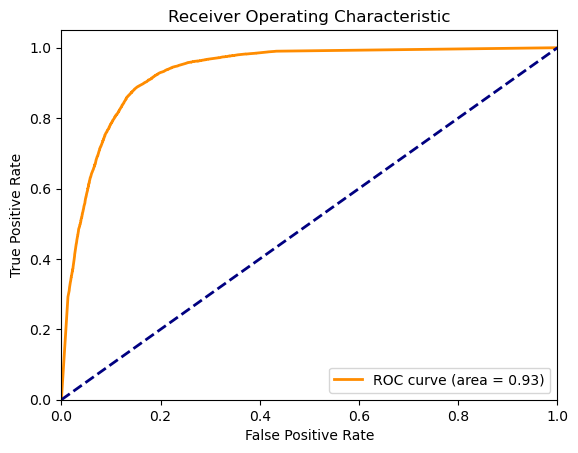

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities
y_prob = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters
print(f'Best parameters found: {grid_search.best_params_}')

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print(f'Accuracy of the best model: {accuracy_score(y_test, y_pred_best):.2f}')


Fitting 3 folds for each of 108 candidates, totalling 324 fits


In [ ]:
# Get feature importances
importances = model.feature_importances_
feature_names = features

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print('Feature Importances:')
print(feature_importances)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()


In [ ]:
def get_manual_input():
    # Prompt the user for input values
    previous_day_attendance = int(input("Previous Day Attendance (1 for Present, 0 for Absent): "))
    total_workdays = int(input("Total Workdays up to Today: "))
    total_attended = int(input("Total Attended Days up to Today: "))
    
    # Create a DataFrame for the input
    input_data = pd.DataFrame({
        'Previous_Day_Attendance': [previous_day_attendance],
        'Total_Workdays': [total_workdays],
        'Total_Attended': [total_attended]
    })
    
    return input_data


In [ ]:
def predict_manual_input(model):
    # Get the manual input
    input_data = get_manual_input()
    
    # Make a prediction
    prediction = model.predict(input_data)
    prediction_prob = model.predict_proba(input_data)[:, 1]
    
    # Output the prediction
    attendance_status = "Present" if prediction[0] == 1 else "Absent"
    print(f"Predicted Attendance Status: {attendance_status}")
    print(f"Prediction Probability: {prediction_prob[0]:.2f}")

# Call the function to test the model with manual input
predict_manual_input(model)
